In [1]:
import seaborn as sns
import sdeint
import matplotlib.pyplot as plt
import pandas as pd
import sympy as smp
import random
import numpy as np
import pycatch22 as catch22
from metric_learn import MMC_Supervised
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.manifold import MDS
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.metrics import log_loss
from scipy.optimize import fsolve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, FunctionTransformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA, FactorAnalysis
from time import perf_counter

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def gen_gaussianNoise(sigma, N):
    """Generate Gaussian noise"""
    return np.random.normal(0, sigma, N)

In [3]:
def sample_gaussianNoise(n_samples, N=None, sigma=None):
    """Sample from Gaussian noise"""
    if N is not None:
        N = np.repeat(N, n_samples)
    else:
        N = np.random.randint(50, 5000, n_samples)
    if sigma is not None:
        sigma = np.repeat(sigma, n_samples)
    else:
        sigma = np.random.uniform(0, 1, n_samples)
    ts = list()
    lengths = list()
    for i in range(n_samples):
        ts.append(gen_gaussianNoise(sigma[i], N[i]))
        lengths.append(len(ts[i]))
    
    features = np.array([catch22.catch22_all(ts[i])['values'] for i in range(n_samples)])
    df = pd.DataFrame(features)
    df['N'] = lengths
    df['model'] = 'GaussianNoise'
    df['metaModel'] = 'StochasticProcess'

    return ts, df

In [4]:
def gen_uniformNoise(N):
    """Generate Uniform noise"""
    return np.random.uniform(size=N)

In [5]:
def sample_uniformNoise(n_samples, N=None):
    """Sample from Uniform noise"""
    if N is not None:
        N = np.repeat(N, n_samples)
    else:
        N = np.random.randint(50, 5000, n_samples)
    ts = list()
    lengths = list()
    for i in range(n_samples):
        ts.append(gen_uniformNoise(N[i]))
        lengths.append(len(ts[i]))
    
    features = np.array([catch22.catch22_all(ts[i])['values'] for i in range(n_samples)])
    df = pd.DataFrame(features)
    df['N'] = lengths
    df['model'] = 'UniformNoise'
    df['metaModel'] = 'StochasticProcess'

    return ts, df

In [6]:
def gen_cauchyNoise(N):
    """Generate Cauchy noise"""
    return np.random.standard_cauchy(N)

In [7]:
def sample_cauchyNoise(n_samples, N=None):
    """Sample from Cauchy distribution"""
    if N is not None:
        N = np.repeat(N, n_samples)
    else:
        N = np.random.randint(50, 5000, n_samples)
    ts = list()
    lengths = list()
    for i in range(n_samples):
        ts.append(gen_cauchyNoise(N[i]))
        lengths.append(len(ts[i]))
    
    features = np.array([catch22.catch22_all(ts[i])['values'] for i in range(n_samples)])
    df = pd.DataFrame(features)
    df['N'] = lengths
    df['model'] = 'CauchyNoise'
    df['metaModel'] = 'StochasticProcess'

    return ts, df

In [8]:
def gen_expNoise(lam, N):
    """Generate Exponential noise"""
    return np.random.exponential(scale=lam, size=N)

In [9]:
def sample_expNoise(n_samples, N=None, lam=None):
    """Sample from Exponential distribution"""
    if N is not None:
        N = np.repeat(N, n_samples)
    else:
        N = np.random.randint(50, 5000, n_samples)
    if lam is not None:
        lam = np.repeat(lam, n_samples)
    else:
        lam = np.random.uniform(0, 1, n_samples)
    ts = list()
    lengths = list()
    for i in range(n_samples):
        ts.append(gen_expNoise(lam[i], N[i]))
        lengths.append(len(ts[i]))
    
    features = np.array([catch22.catch22_all(ts[i])['values'] for i in range(n_samples)])
    df = pd.DataFrame(features)
    df['N'] = lengths
    df['model'] = 'ExpNoise'
    df['metaModel'] = 'StochasticProcess'

    return ts, df

In [10]:
def gen_AR1(phi, sigma, N):
    """Generate an AR1 process

    Parameters
    ----------
    phi : float
        Autoregressive parameter
    sigma : float
        Standard deviation of the noise
    N : int
        Number of samples
    """
    x_0 = np.random.normal()
    transient = 500
    x = np.zeros(N+transient)
    x[0] = x_0
    for i in range(1, N+transient):
        x[i] = phi * x[i-1] + sigma * np.random.normal()
    return x[transient:]

In [11]:
def sample_AR1(n_samples, N=None, eta=None, seed=4576):
    """Sample AR(1) time series of length N

    Args:
        n_samples (int): number of samples to generate
        N (int): length of time series
        eta (float): noise level (sigma)
        seed (int): random seed for reproducing results
    
    Returns:
        ts (list): list of time series
        df (pd.DataFrame): dataframe of time series
    """
    np.random.seed(seed)
    if N is not None:
        N = np.repeat(N, n_samples)
    else:
        N = np.random.randint(50, 5000, n_samples)
    if eta is not None:
        eta = np.repeat(eta, n_samples)
    else:
        eta = np.random.uniform(0, 1, n_samples)
    phi = np.random.uniform(-0.99, 1, n_samples)
    ts = list()
    lengths = list()
    for i in range(n_samples):
        ts.append(gen_AR1(phi[i], eta[i], N[i]))
        lengths.append(len(ts[i]))
    
    features = np.array([catch22.catch22_all(ts[i])['values'] for i in range(n_samples)])
    df = pd.DataFrame(features)
    df['N'] = lengths
    df['eta'] = eta
    df['phi'] = phi
    df['system'] = 'AR1'

    return ts, df
    

In [12]:
def gen_AR2(phi1, phi2, sigma, N):
    """Generate an AR2 process

    Parameters
    ----------
    phi1 : float
        Autoregressive parameter 1
    phi2 : float
        Autoregressive parameter 2
    sigma : float
        Standard deviation of the noise
    N : int
        Number of samples
    """
    x_0 = np.random.normal()
    x_1 = np.random.normal()
    transient = 500
    x = np.zeros(N+transient)
    x[0] = x_0
    x[1] = x_1
    for i in range(2, N+transient):
        x[i] = phi1 * x[i-1] + phi2 * x[i-2] + sigma * np.random.normal()
    return x[transient:]

In [13]:
def sample_AR2(n_samples, N=None, eta=None, seed=34856):
    """Sample AR(2) time series of length N

    Args:
        n_samples (int): number of samples to generate
        N (int): length of time series
        eta (float): noise level (sigma)
        seed (int): random seed for reproducing results
    
    Returns:
        ts (list): list of time series
        df (pd.DataFrame): dataframe of time series
    """
    np.random.seed(seed)
    if N is not None:
        N = np.repeat(N, n_samples)
    else:
        N = np.random.randint(50, 5000, n_samples)
    if eta is not None:
        eta = np.repeat(eta, n_samples)
    else:
        eta = np.random.uniform(0, 1, n_samples)

    # AR(2) is stationary if phi1 + phi2 < 1 and phi2 - phi1 < 1 and |phi2| < 1
    phi1_store = list()
    phi2_store = list()
    ts = list()
    lengths = list()
    count = 0
    while count < n_samples:
        phi1 = np.random.uniform(-0.99, 1)
        phi2 = np.random.uniform(-0.99, 1)
        if phi1 + phi2 < 1 and phi2 - phi1 < 1 and abs(phi2) < 1:
            phi1_store.append(phi1)
            phi2_store.append(phi2)
            ts.append(gen_AR2(phi1, phi2, eta[count], N[count]))
            lengths.append(len(ts[count]))
            count += 1
    
    features = np.array([catch22.catch22_all(ts[i])['values'] for i in range(n_samples)])
    df = pd.DataFrame(features)
    df['N'] = lengths
    df['eta'] = eta
    df['phi1'] = phi1
    df['phi2'] = phi2
    df['system'] = 'AR2'

    return ts, df

In [14]:
def sample_noise(samples_per_distribution, N=None, seed=12345):
    """Sample noise from the following distributions:
        - Cauchy
        - Gaussian
        - Uniform
        - Exponential
    """
    ts_cauch, df_cauch = sample_cauchyNoise(samples_per_distribution, N=N)
    ts_gauss, df_gauss = sample_gaussianNoise(samples_per_distribution, N=N)
    ts_unif, df_unif = sample_uniformNoise(samples_per_distribution, N=N)
    ts_exp, df_exp = sample_expNoise(samples_per_distribution, N=N)
    ts = ts_cauch + ts_gauss + ts_unif + ts_exp
    df = pd.concat([df_cauch, df_gauss, df_unif, df_exp], ignore_index=True)

    return ts, df
    


In [15]:
ts, df = sample_noise(10000)

In [16]:
rs = RobustScaler().fit(df.iloc[:,:22])
rs_transformed = rs.transform(df.iloc[:,:22])
def sigmoid(x, theta):
    return 1/(1+np.exp(-theta*x))
sig = FunctionTransformer(sigmoid, kw_args={'theta': 1.35})
sig_transformed = sig.transform(rs_transformed)
mm = MinMaxScaler().fit(sig_transformed)
mm_transformed = mm.transform(sig_transformed)
xhat = mm_transformed
pca = PCA(n_components=2).fit(xhat)
xhat_pca = pca.transform(xhat)

In [17]:
le = LabelEncoder().fit(df['model'])
y = le.transform(df['model'])

In [18]:
mmc = MMC_Supervised(random_state=82)
mmc_fit = mmc.fit(xhat, y)
X_mmc = mmc_fit.transform(xhat)
learned_metric = mmc.get_metric()

In [19]:
pca_opt = PCA(n_components=2)
pca_opt_fit = pca_opt.fit_transform(X_mmc)

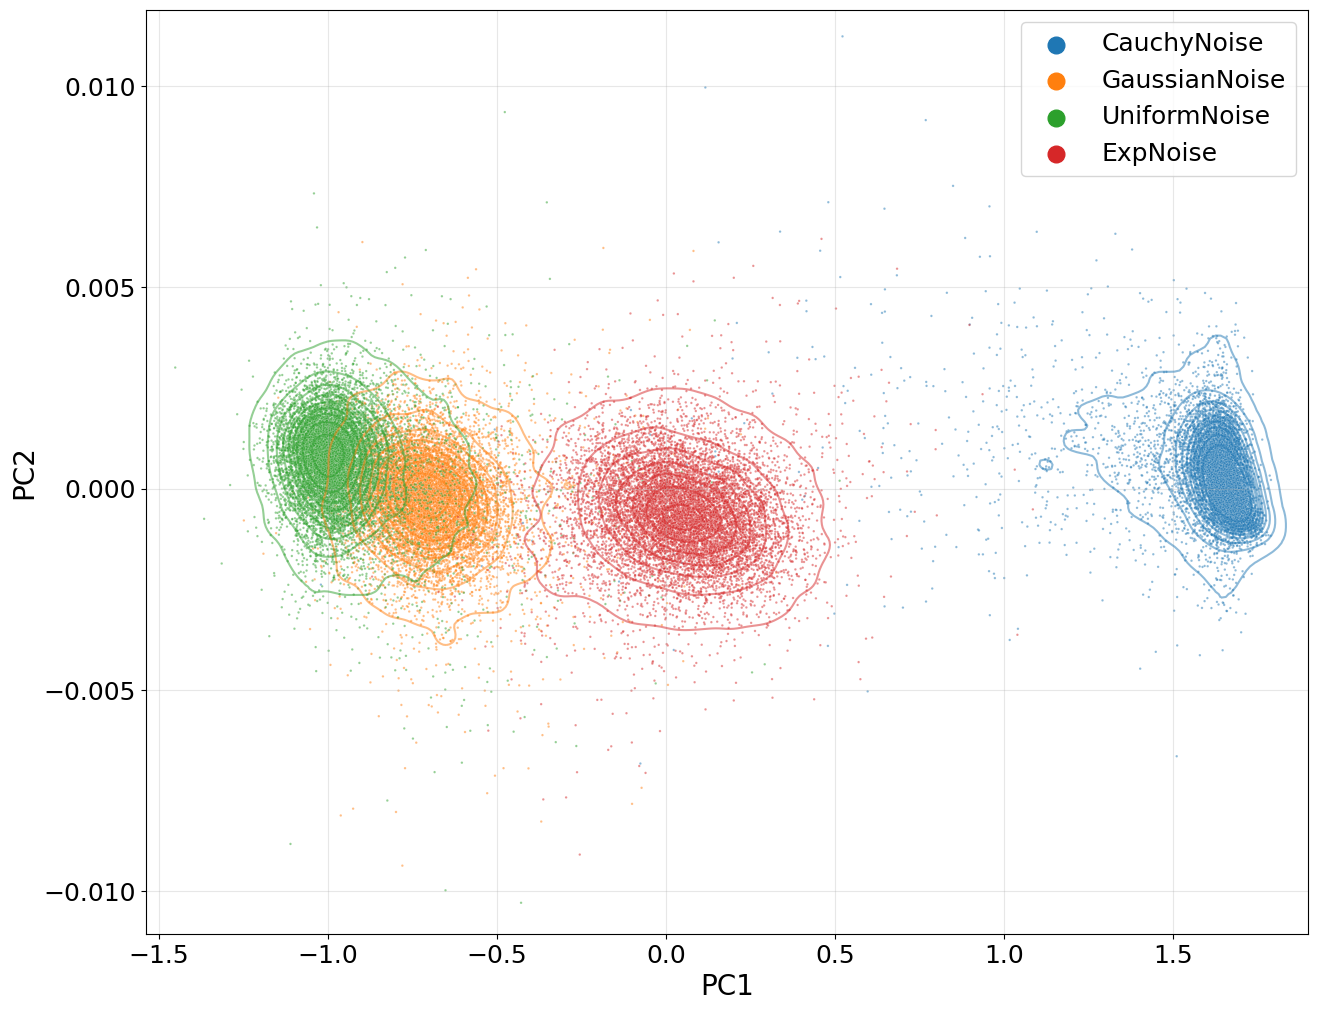

In [129]:
plt.figure(figsize=(15,12))
plt.grid(alpha=0.3)
sns.scatterplot(x=pca_opt_fit[:,0], y=pca_opt_fit[:,1], hue=df['model'], s=3, alpha=0.5)
sns.kdeplot(x=pca_opt_fit[:,0], y=pca_opt_fit[:,1], hue=df['model'], alpha=0.5)
plt.xlabel('PC1', fontsize=20)
plt.ylabel('PC2', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.title('Optimised Feature Space Projection, PCA', fontsize=20)
plt.legend(fontsize=18, markerscale=2)
#plt.savefig('optimised_feature_space_pca.png', dpi=400, bbox_inches='tight', transparent=True)
plt.show()

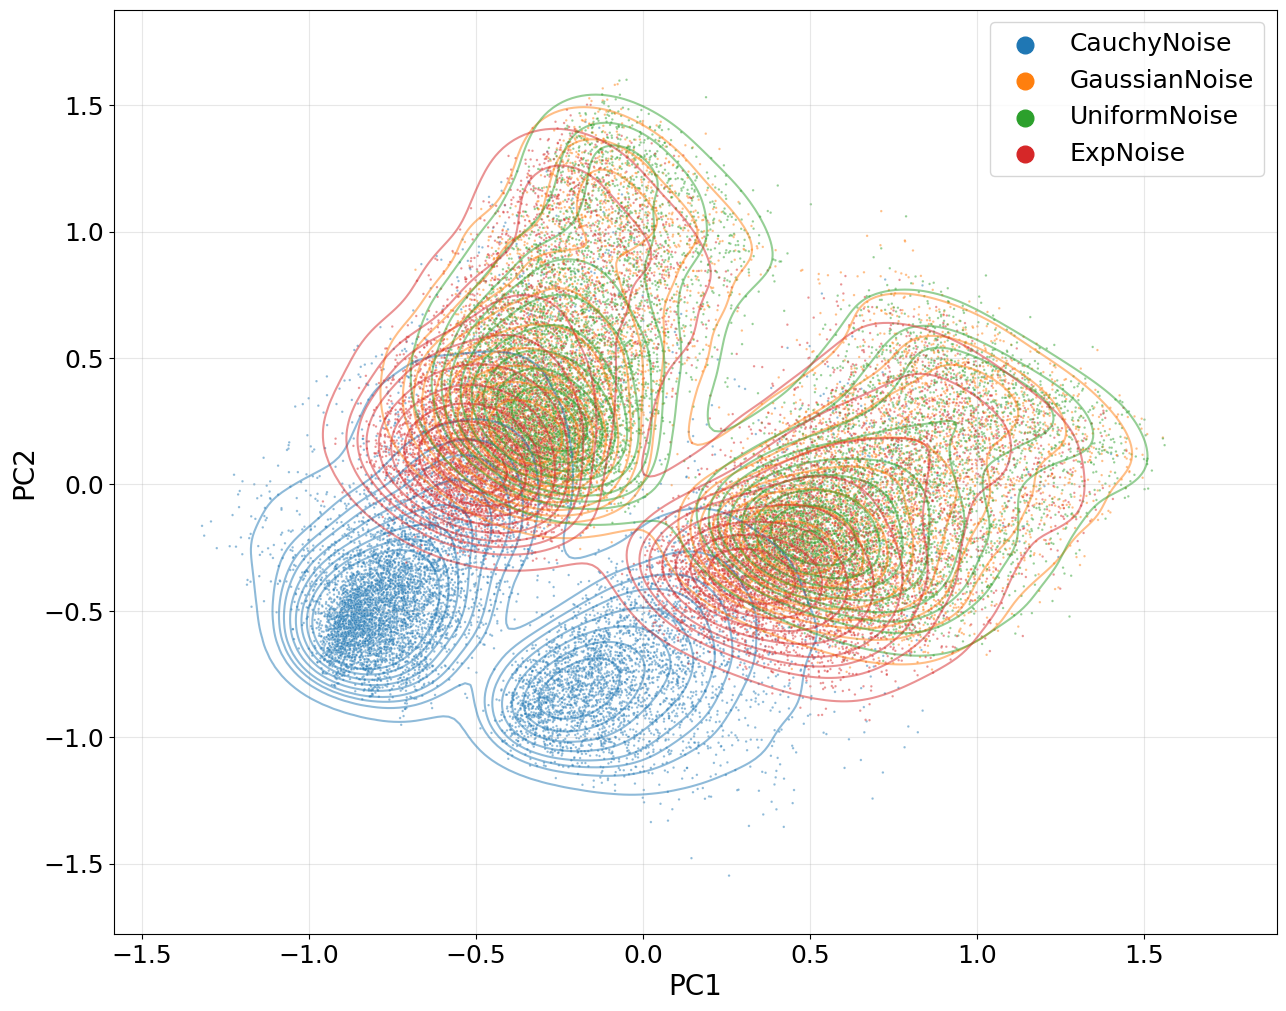

In [143]:
plt.figure(figsize=(15,12))
plt.grid(alpha=0.3)
sns.scatterplot(x=xhat_pca[:,0], y=xhat_pca[:,1], hue=df['model'], s=3, alpha=0.5)
sns.kdeplot(x=xhat_pca[:,0], y=xhat_pca[:,1], hue=df['model'], alpha=0.5)
plt.xlabel('PC1', fontsize=20)
plt.ylabel('PC2', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.title('Optimised Feature Space Projection, PCA', fontsize=20)
plt.legend(fontsize=18, markerscale=2)
plt.savefig('unoptimised_feature_space_pca.png', dpi=400, bbox_inches='tight', transparent=True)
#plt.show()

In [38]:
plt.style.use('default')

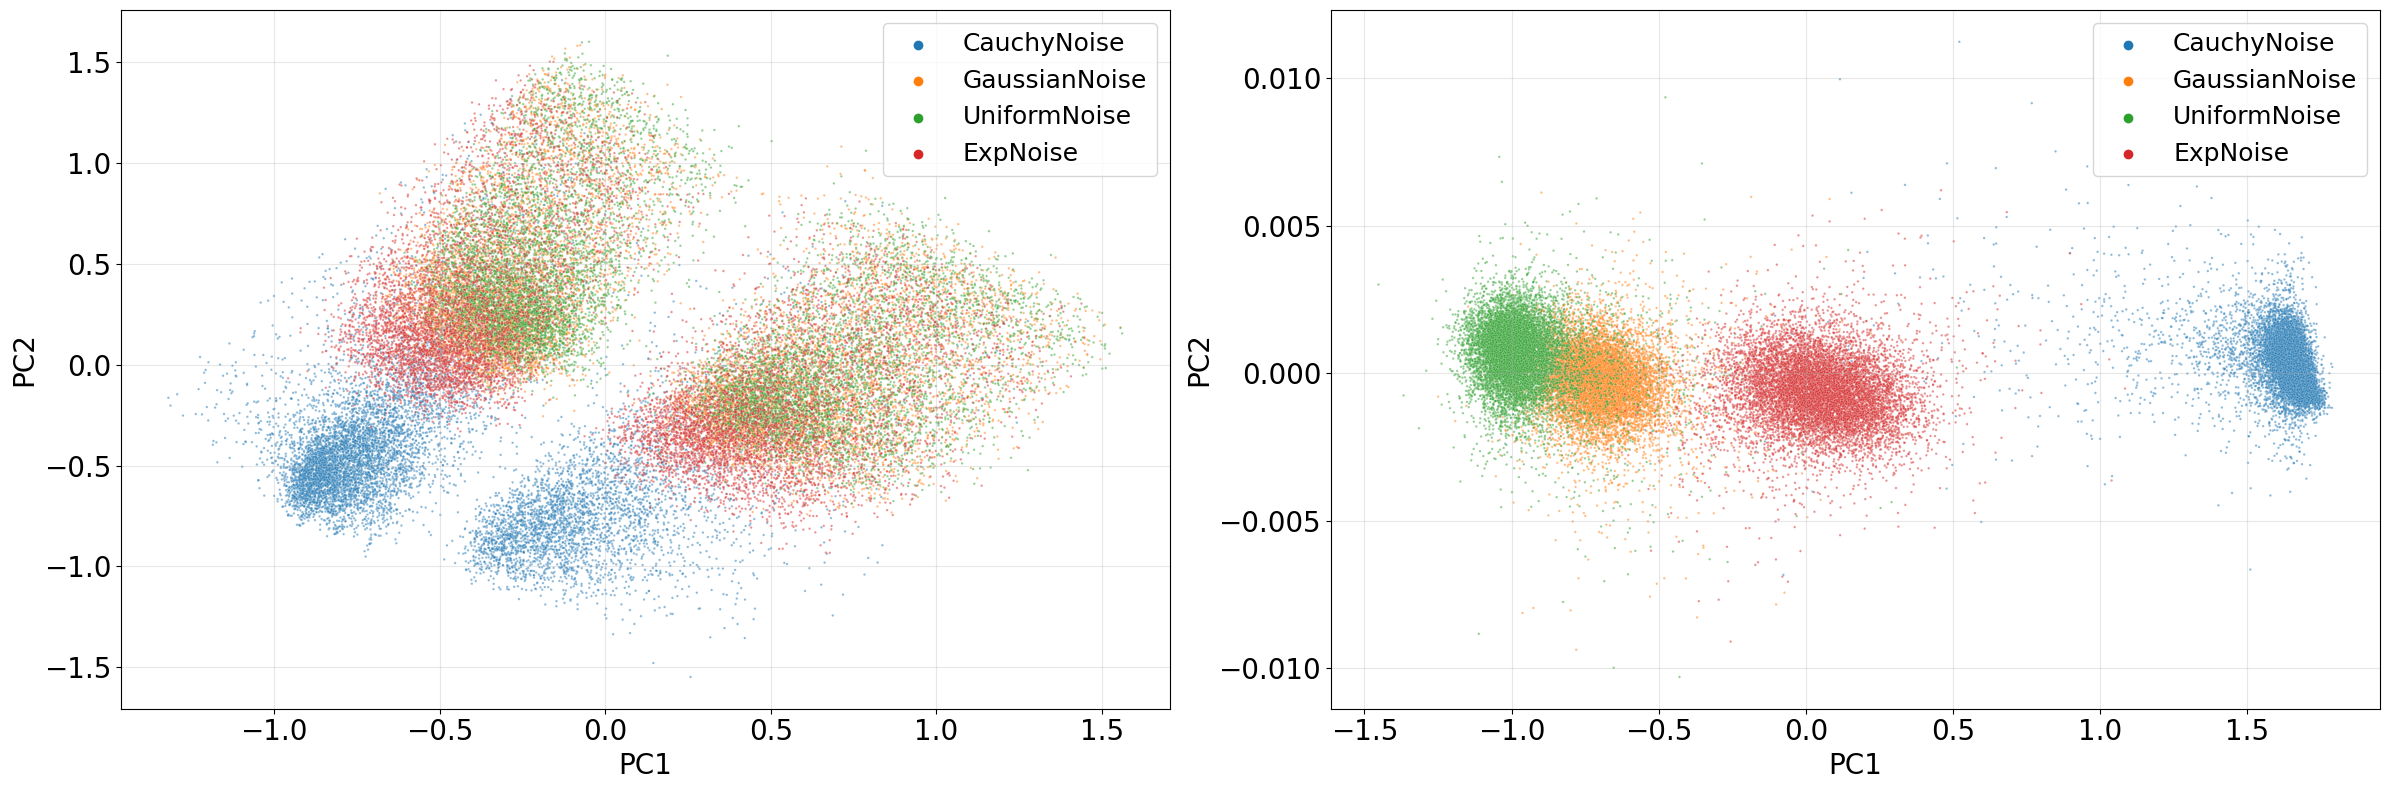

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(24,8))
ax[0].grid(alpha=0.3)
ax[1].grid(alpha=0.3)
sns.scatterplot(x=xhat_pca[:,0], y=xhat_pca[:,1], hue=df['model'], s=3, ax=ax[0], alpha=0.5)
sns.scatterplot(x=pca_opt_fit[:,0], y=pca_opt_fit[:,1], hue=df['model'], s=3, ax=ax[1], alpha=0.5)
#sns.kdeplot(x=pca_opt_fit[:,0], y=pca_opt_fit[:,1], ax=ax[1], alpha=0.5, hue=df['model'])
#sns.kdeplot(x=xhat_pca[:,0], y=xhat_pca[:,1], ax=ax[0], alpha=0.5, hue=df['model'])
ax[1].set_xlabel('PC1', fontsize=20)
ax[1].set_ylabel('PC2', fontsize=20)
ax[0].set_xlabel('PC1', fontsize=20)
ax[0].set_ylabel('PC2', fontsize=20)
ax[1].legend(fontsize=18)
ax[0].legend(fontsize=18)
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
#plt.show()
#plt.savefig('figures/optimised_feature_space.png', dpi=800)

In [38]:
#ts_eval, df_eval = sample_noise(1000)
ts_gauss_opt, df_gauss_opt = sample_gaussianNoise(n_samples=1000)
ts_unif_opt, df_unif_opt = sample_uniformNoise(n_samples=1000)
ts_exp_opt, df_exp_opt = sample_expNoise(n_samples=1000)
ts_cauchy_opt, df_cauchy_opt = sample_cauchyNoise(n_samples=1000)
ts_opt = ts_gauss_opt + ts_unif_opt + ts_exp_opt + ts_cauchy_opt
df_opt = pd.concat([df_gauss_opt, df_unif_opt, df_exp_opt, df_cauchy_opt], ignore_index=True)

In [21]:
x_hat_eval = mm.transform(sig.transform(rs.transform(df_opt.iloc[:,:22])))

In [22]:
y_eval = le.transform(df_opt['model'])

In [23]:
radii = np.linspace(0.5, 1.5, 50)
log_loss_values = list()
scores = list()
for radius in radii:
    rnc_optimised = RadiusNeighborsClassifier(radius=radius, outlier_label='most_frequent')
    rnc_optimised.fit(xhat, df['model'])
    y_pred = rnc_optimised.predict_proba(x_hat_eval)
    log_loss_value = log_loss(df_opt['model'], y_pred)
    score = rnc_optimised.score(x_hat_eval, df_opt['model'])
    log_loss_values.append(log_loss_value)
    scores.append(score)

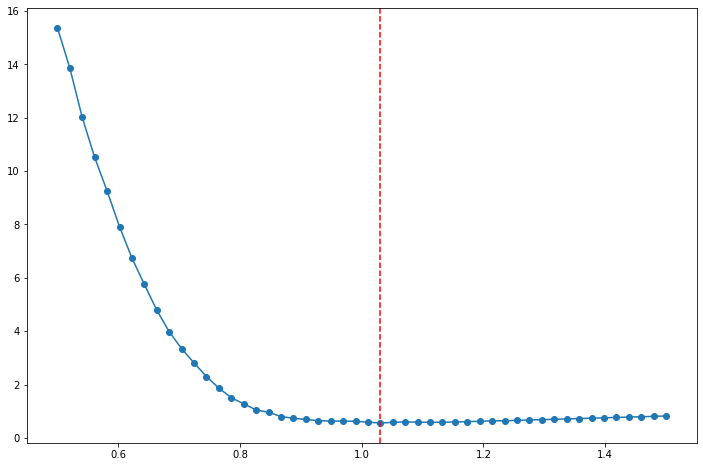

In [24]:
plt.figure(figsize=(12,8))
plt.plot(radii, log_loss_values, marker='o')
plt.axvline(radii[np.argmin(log_loss_values)], color='r', linestyle='--')

In [30]:
radii[np.argmin(log_loss_values)]

1.030612244897959

In [31]:
np.min(log_loss_values)

0.5558406649440842

In [33]:
radii = np.linspace(0.01, 0.05, 50)
logloss_val = list()
acc = list()
for r in radii:
    rnc = RadiusNeighborsClassifier(radius=r, outlier_label='most_frequent').fit(X_mmc, y)
    Xhat_mmc = mmc.transform(x_hat_eval)
    y_pred = rnc.predict_proba(Xhat_mmc)
    logloss_val.append(log_loss(y_eval, y_pred))
    acc.append(rnc.score(Xhat_mmc, df_opt['model']))

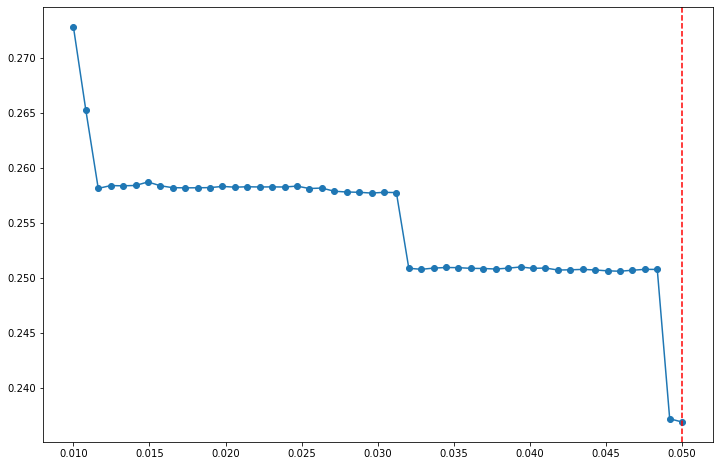

In [34]:
plt.figure(figsize=(12,8))
plt.plot(radii, logloss_val, marker='o')
plt.axvline(radii[np.argmin(logloss_val)], color='r', linestyle='--')

In [36]:
radii[np.argmin(logloss_val)]

0.05

In [37]:
np.min(logloss_val)

0.23691354748215246

In [236]:
ts_gauss, df_gauss = sample_gaussianNoise(n_samples=1000)
ts_unif, df_unif = sample_uniformNoise(n_samples=1000)
ts_exp, df_exp = sample_expNoise(n_samples=1000)
ts_cauchy, df_cauchy = sample_cauchyNoise(n_samples=1000)

In [237]:
df_combined = pd.concat([df_gauss, df_unif, df_exp, df_cauchy], ignore_index=True)

In [238]:
x_hat_combined_eval = mm.transform(sig.transform(rs.transform(df_combined.iloc[:,:22])))

In [239]:
y_eval = le.transform(df_combined['model'])

In [240]:
rnc_unopt = RadiusNeighborsClassifier(radius=0.9286, outlier_label='most_frequent')
rnc_unopt.fit(xhat, df['model'])
y_pred_unopt = rnc_unopt.predict_proba(x_hat_combined_eval)

In [241]:
rnc_unopt.score(x_hat_combined_eval, df_combined['model'])

0.8935

In [242]:
rnc_opt = RadiusNeighborsClassifier(radius=0.03612, outlier_label='most_frequent')
rnc_opt.fit(X_mmc, df['model'])
combined_mmc = mmc.transform(x_hat_combined_eval)
y_pred_opt = rnc_opt.predict_proba(combined_mmc)

In [243]:
rnc_opt.score(combined_mmc, df_combined['model'])

0.9425

## Summary

Optimised space provides higher accuracy (85.7% vs 93.7%). We will now compare average log-loss across each of the models for both optimised and unoptimised cases. This should elucidate the difference in performance, particularly with respect to differentiating between uniform and gaussian noise sequences. We expect high log-loss in the unoptimised case due ti high confusion between the two as they are difficult to distinguish. 

In [27]:
ll_opt = log_loss(y_eval, y_pred_opt)
ll_unopt = log_loss(y_eval, y_pred_unopt)

NameError: name 'y_pred_opt' is not defined

In [245]:
class_names = le.classes_
n_classes = len(class_names)

opt_class_log_losses = []
unopt_class_log_losses = []

for cls in range(n_classes):
    binary_labels = (y_eval == cls).astype(int)

    opt_class_probs = y_pred_opt[:, cls]
    unopt_class_probs = y_pred_unopt[:, cls]

    opt_cls_log_loss = log_loss(binary_labels, opt_class_probs)
    unopt_cls_log_loss = log_loss(binary_labels, unopt_class_probs)

    opt_class_log_losses.append(opt_cls_log_loss)
    unopt_class_log_losses.append(unopt_cls_log_loss)

    print(f"Average log-loss (opt) for {class_names[cls]}: {opt_cls_log_loss}")
    print(f"Average log-loss (unopt) for {class_names[cls]}: {unopt_cls_log_loss}")

print(f"Overall log-loss (opt): {log_loss(y_eval, y_pred_opt)}")
print(f"Overall log-loss (unopt): {log_loss(y_eval, y_pred_unopt)}")



Average log-loss (opt) for CauchyNoise: 0.013650948273816622
Average log-loss (unopt) for CauchyNoise: 0.10654722400424221
Average log-loss (opt) for ExpNoise: 0.03550542869248565
Average log-loss (unopt) for ExpNoise: 0.23757081072735953
Average log-loss (opt) for GaussianNoise: 0.14777103709548023
Average log-loss (unopt) for GaussianNoise: 0.3818354713894937
Average log-loss (opt) for UniformNoise: 0.1387431682373969
Average log-loss (unopt) for UniformNoise: 0.3003612606970929
Overall log-loss (opt): 0.17968065564736274
Overall log-loss (unopt): 0.543597634161655


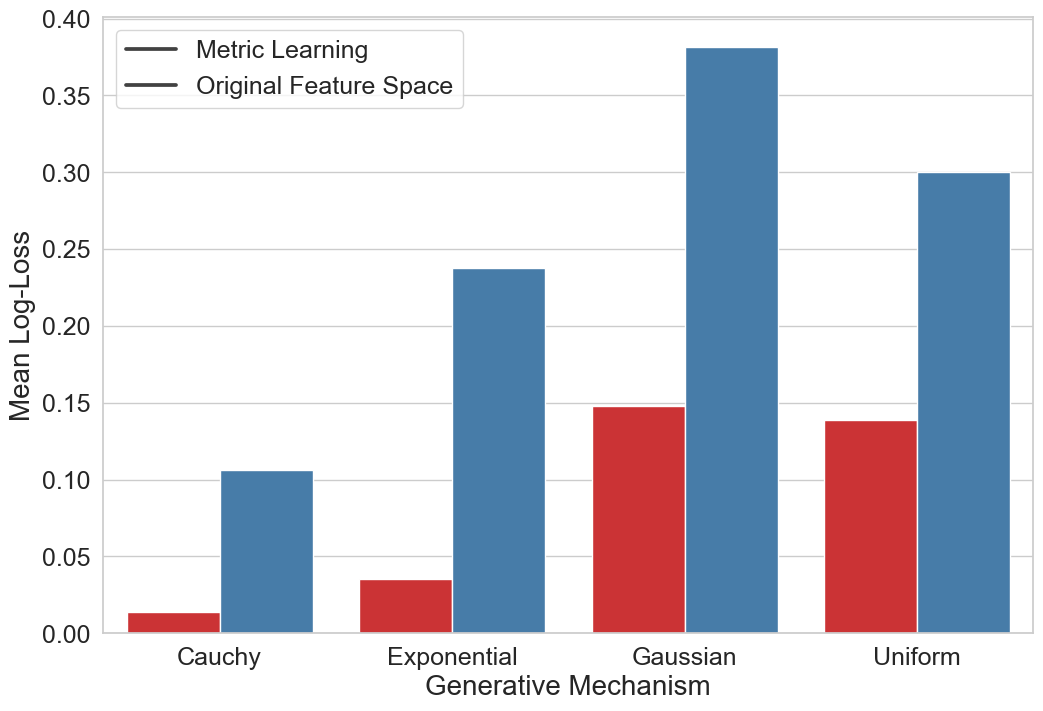

In [252]:
data = pd.DataFrame({"Class": np.tile(class_names, 2),
                     "Optimization": ["Optimised Space"] * n_classes + ["Unoptimised Space"] * n_classes,
                     "Average Log-Loss": opt_class_log_losses + unopt_class_log_losses})


sns.set(style="whitegrid")


plt.figure(figsize=(12, 8))
barplot = sns.barplot(x="Class", y="Average Log-Loss", hue="Optimization", data=data, palette='Set1')

class_names_new = ['Cauchy', 'Exponential', 'Gaussian', 'Uniform']
plt.xlabel("Generative Mechanism", fontsize=20)
plt.ylabel("Mean Log-Loss", fontsize=20)
plt.xticks(np.arange(n_classes), class_names_new, fontsize=18)
plt.yticks(fontsize=18)

legend_labels = ['Metric Learning', 'Original Feature Space']
legend = plt.legend(title=None, loc='upper left',fontsize=18, labels=legend_labels)


#plt.show()
#plt.savefig('logloss_metric_learning.png', dpi=800)

Low Noise Case

In [262]:
ts_eval_short1, df_eval_short1 = sample_noise(1000, N=100, seed=988656)
x_hat_eval_short1 = mm.transform(sig.transform(rs.transform(df_eval_short1.iloc[:,:22])))
y_eval_short1 = le.transform(df_eval_short1['model'])

In [263]:
y_pred_unopt_short1 = rnc_unopt.predict_proba(x_hat_eval_short1)
mmc_short1 = mmc.transform(x_hat_eval_short1)
y_pred_opt_short1 = rnc_opt.predict_proba(mmc_short1)

In [264]:
ll_opt_short1 = log_loss(y_eval_short1, y_pred_opt_short1)
ll_unopt_short1 = log_loss(y_eval_short1, y_pred_unopt_short1)

In [265]:
class_names = le.classes_
n_classes = len(class_names)

opt_class_log_losses = []
unopt_class_log_losses = []

for cls in range(n_classes):
    binary_labels = (y_eval_short1 == cls).astype(int)

    opt_class_probs = y_pred_opt_short1[:, cls]
    unopt_class_probs = y_pred_unopt_short1[:, cls]

    opt_cls_log_loss = log_loss(binary_labels, opt_class_probs)
    unopt_cls_log_loss = log_loss(binary_labels, unopt_class_probs)

    opt_class_log_losses.append(opt_cls_log_loss)
    unopt_class_log_losses.append(unopt_cls_log_loss)

    print(f"Average log-loss (opt) for {class_names[cls]}: {opt_cls_log_loss}")
    print(f"Average log-loss (unopt) for {class_names[cls]}: {unopt_cls_log_loss}")

print(f"Overall log-loss (opt): {log_loss(y_eval_short1, y_pred_opt_short1)}")
print(f"Overall log-loss (unopt): {log_loss(y_eval_short1, y_pred_unopt_short1)}")

Average log-loss (opt) for CauchyNoise: 0.42784914169278226
Average log-loss (unopt) for CauchyNoise: 2.080129960971093
Average log-loss (opt) for ExpNoise: 0.8442886654667664
Average log-loss (unopt) for ExpNoise: 1.2336313402228052
Average log-loss (opt) for GaussianNoise: 0.850543360429682
Average log-loss (unopt) for GaussianNoise: 1.4655506825368816
Average log-loss (opt) for UniformNoise: 0.7040105686663276
Average log-loss (unopt) for UniformNoise: 1.540787155036162
Overall log-loss (opt): 1.6824840432763222
Overall log-loss (unopt): 3.7348134661048125


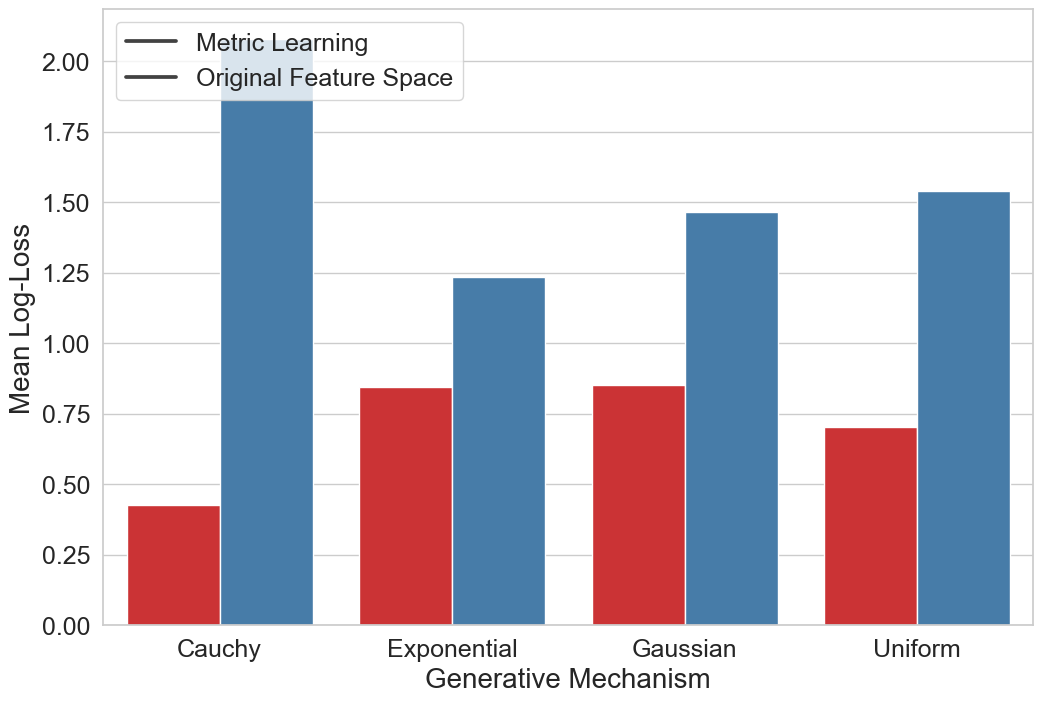

In [266]:
# Create a DataFrame to store the results
data = pd.DataFrame({"Class": np.tile(class_names, 2),
                     "Optimization": ["Optimised Space"] * n_classes + ["Unoptimised Space"] * n_classes,
                     "Average Log-Loss": opt_class_log_losses + unopt_class_log_losses})

# Set the Seaborn style
sns.set(style="whitegrid")

# Create the bar plot using Seaborn
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x="Class", y="Average Log-Loss", hue="Optimization", data=data, palette='Set1')

class_names_new = ['Cauchy', 'Exponential', 'Gaussian', 'Uniform']
# Customize the plot
plt.xlabel("Generative Mechanism", fontsize=20)
plt.ylabel("Mean Log-Loss", fontsize=20)
plt.xticks(np.arange(n_classes), class_names_new, fontsize=18)
plt.yticks(fontsize=18)

# Change the legend labels
legend_labels = ['Metric Learning', 'Original Feature Space']
legend = plt.legend(title=None, loc='upper left',fontsize=18, labels=legend_labels)


## Compare mean log-loss across all class predictions over various Ns

In [292]:
def compute_log_losses(N_values):
    opt_log_losses = []
    unopt_log_losses = []

    for N in N_values:
        ts_eval, df_eval = sample_noise(1000, N=N, seed=988656)
        x_hat_eval = mm.transform(sig.transform(rs.transform(df_eval.iloc[:,:22])))
        y_eval = le.transform(df_eval['model'])
    
        y_pred_unopt = rnc_unopt.predict_proba(x_hat_eval)
        mmc_short = mmc.transform(x_hat_eval)
        y_pred_opt = rnc_opt.predict_proba(mmc_short)

        ll_opt = log_loss(y_eval, y_pred_opt)
        ll_unopt = log_loss(y_eval, y_pred_unopt)

        opt_log_losses.append(ll_opt)
        unopt_log_losses.append(ll_unopt)
        
    return opt_log_losses, unopt_log_losses

N_values = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
opt_log_losses, unopt_log_losses = compute_log_losses(N_values)

In [293]:
plt.style.use('default')

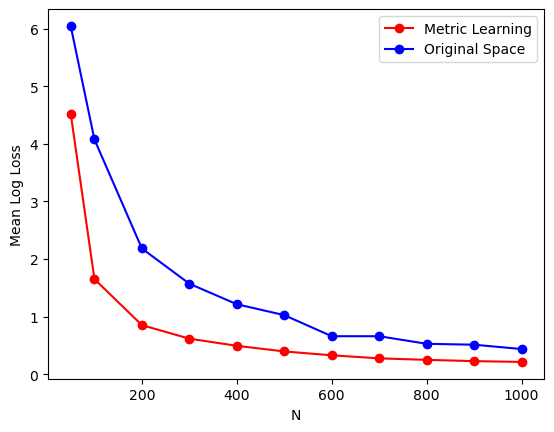

In [295]:
plt.plot(N_values, opt_log_losses, label='Metric Learning', color='red', marker='o')
plt.plot(N_values, unopt_log_losses, label='Original Space', color='blue', marker='o')
plt.xlabel('N')
plt.ylabel('Mean Log Loss')
plt.legend()
plt.show()